In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train_raw = pd.read_csv('train_data.csv', parse_dates=['startdate'])
test_raw = pd.read_csv('test_data.csv', parse_dates=['startdate'])
submit = pd.read_csv('sample_solution.csv')
target = 'contest-tmp2m-14d__tmp2m'
train_raw.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

In [4]:
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

def location_nom(train, test):
    # Ref: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved
    scale = 14

    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)

    all_df = pd.concat([train, test], axis=0)
    all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
    train = all_df.iloc[:len(train)]
    test = all_df.iloc[len(train):].drop(target, axis=1)
    
    return train, test

def categorical_encode(train, test):
    le = LabelEncoder()
    train['climateregions__climateregion'] = le.fit_transform(train['climateregions__climateregion'])
    test['climateregions__climateregion'] = le.transform(test['climateregions__climateregion'])
    return train, test
    
def fill_na(df):
    df = df.sort_values(by=['loc_group', 'startdate']).ffill()
    return df

def creat_new_featute(df):
    df['year'] = df['startdate'].dt.year
    df['month'] = df['startdate'].dt.month
    df['day_of_year'] = df['startdate'].dt.dayofyear
    # df['day_of_week'] = df['startdate'].dt.dayofweek
    # df['week_of_year'] = df['startdate'].dt.isocalendar().week
    return df

def feature_engineering(train_raw, test_raw):
    train, test = location_nom(train_raw, test_raw)
    train = fill_na(train)
    train = creat_new_featute(train)
    test = creat_new_featute(test)
    train, test = categorical_encode(train, test)

    drop_cols = ['index', 'startdate', 'lat', 'lon', target]
    features = [col for col in train.columns if col not in drop_cols]
    X = train[features]
    X_test = test[features]
    y = train[target]

    return X, y, X_test

In [5]:
X, y, X_test = feature_engineering(train_raw.copy(), test_raw.copy())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_val.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (251741, 245)    |   Val_shape: (123993, 245)    |   Test_shape: (31354, 245)


In [6]:
model = CatBoostRegressor(n_estimators=1000, verbose=100, learning_rate=0.1, l2_leaf_reg=5)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 9.0070842	test: 9.0021982	best: 9.0021982 (0)	total: 335ms	remaining: 5m 34s
100:	learn: 1.2772056	test: 1.2797569	best: 1.2797569 (100)	total: 13s	remaining: 1m 56s
200:	learn: 1.0167709	test: 1.0232850	best: 1.0232850 (200)	total: 24.9s	remaining: 1m 38s
300:	learn: 0.8807484	test: 0.8902131	best: 0.8902131 (300)	total: 39.8s	remaining: 1m 32s
400:	learn: 0.7922355	test: 0.8032993	best: 0.8032993 (400)	total: 57.3s	remaining: 1m 25s
500:	learn: 0.7299931	test: 0.7427667	best: 0.7427667 (500)	total: 1m 10s	remaining: 1m 10s
600:	learn: 0.6827323	test: 0.6974698	best: 0.6974698 (600)	total: 1m 25s	remaining: 56.6s
700:	learn: 0.6436786	test: 0.6598064	best: 0.6598064 (700)	total: 1m 41s	remaining: 43.4s
800:	learn: 0.6107891	test: 0.6280704	best: 0.6280704 (800)	total: 1m 57s	remaining: 29.2s
900:	learn: 0.5830437	test: 0.6014032	best: 0.6014032 (900)	total: 2m 12s	remaining: 14.6s
999:	learn: 0.5589310	test: 0.5784144	best: 0.5784144 (999)	total: 2m 28s	remaining: 0us

bestT

Text(0.5, 1.0, 'Feature Importance')

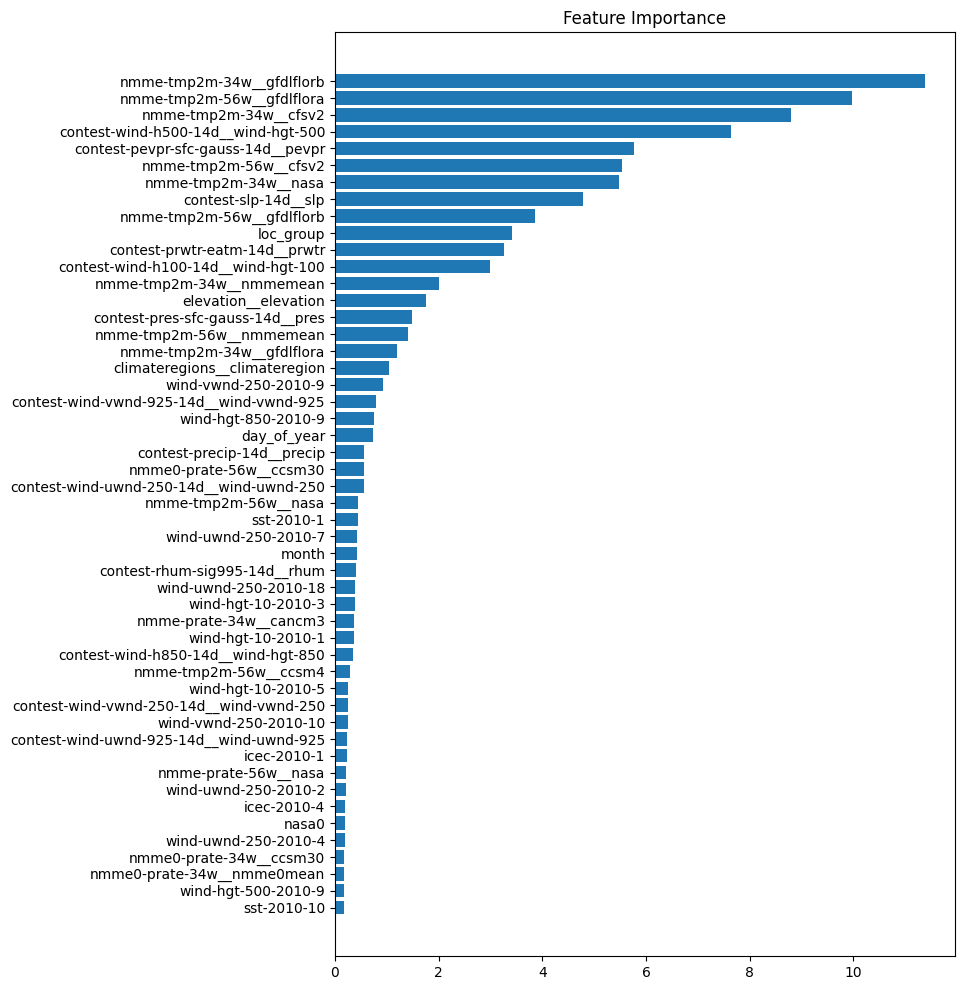

In [10]:
import matplotlib.pyplot as plt
feature_importance = model.feature_importances_
max_features = 50
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [8]:
submit[target] = model.predict(X_test)
submit.to_csv('catboost_submission.csv', index = False)